In [1]:
import os
import re
import json
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import tifffile
from einops import rearrange, repeat

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [6]:
project_dir = Path('/data/estorrs/mushroom/data/projects/submission_v1')
region_dir = project_dir / 'analysis' / 'region_characterization'
fig_dir = region_dir / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)
results_dir = region_dir / 'results'
results_dir.mkdir(parents=True, exist_ok=True)

In [7]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [8]:
case_order = [
    'HT206B1',
    'HT268B1',
    'HT339B2-H1',
    'HT397B1',
    'HT565B1-H2',
    'HT704B1',
    'HT891Z1',
    'HT913Z1',
    'S18-5591-C8',
    'S18-9906',
]

In [9]:
fps = sorted(utils.listfiles(region_dir, regex=r'_regions.txt.gz$'))

sid_to_data = {}
dtype_to_df = {}
for fp in fps:
    name = fp.split('/')[-1]
    sid = re.sub(r'^(.*)_regions.txt.gz$', r'\1', name)
    print(sid)
    case = re.sub(r'^(.*)-U[0-9]+$', r'\1', sid)

    config = yaml.safe_load(open(project_dir / case / 'registered' / 'metadata.yaml'))
    config = alter_filesystem(config, source_root, target_root)

    imaris_dir = project_dir / case / 'imaris' / 'rois'
    meta = json.load(open(imaris_dir / 'tiled' / 'metadata.json'))
    
    sid_to_channels = meta['sid_to_channels']
    dtype_ident_to_dtype = meta['dtype_ident_to_dtype']
    sid_to_dtype_ident = meta['sid_to_dtype_ident']
    dti = sid_to_dtype_ident[sid]
    channels = sid_to_channels[sid]
    dtype = dtype_ident_to_dtype[dti]

    df = pd.read_csv(fp, sep='\t', index_col=0)
    df['case'] = case
    df['sid'] = sid
    df['label'] = df.index.to_list()
    df['dtype'] = dtype
    df['dtype_ident'] = dti
    df['cohort'] = 'serial'

    if case in [
        'HT891Z1',
        'HT913Z1',
        'S18-5591-C8',
        'S18-9906'
    ]:
        df['disease'] = 'prad'
    else:
        df['disease'] = 'brca'
    
    df.index = [f'{sid}_{x}' for x in df.index.to_list()]
    
    sid_to_data[sid] = {
        'df': df,
        'labeled_regions': fp.replace('_regions.txt.gz', '_regions.tif'),
        'labeled_boundaries': fp.replace('_regions.txt.gz', '_boundaries.tif'),
        'labeled_tme': fp.replace('_regions.txt.gz', '_tme.tif'),
        'channels': channels
    }

    if dtype not in dtype_to_df:
        dtype_to_df[dtype] = []
    dtype_to_df[dtype].append(df)

dtype_to_df = {k:pd.concat(v) for k, v in dtype_to_df.items()}

HT206B1-U10
HT206B1-U13
HT206B1-U16
HT206B1-U17
HT206B1-U18
HT206B1-U1
HT206B1-U21
HT206B1-U24
HT206B1-U2
HT206B1-U5
HT206B1-U8
HT206B1-U9
HT339B2-H1-U2
HT397B1-U12
HT397B1-U22
HT397B1-U2
HT397B1-U31
HT565B1-H2-U2
HT704B1-U11
HT704B1-U14
HT704B1-U17
HT704B1-U19
HT704B1-U1
HT704B1-U22
HT704B1-U26
HT704B1-U27
HT704B1-U2
HT704B1-U33
HT704B1-U35
HT704B1-U41
HT704B1-U43
HT704B1-U47
HT704B1-U50
HT704B1-U51
HT704B1-U53
HT704B1-U56
HT704B1-U60
HT704B1-U68
HT704B1-U76
HT704B1-U82
HT704B1-U85
HT704B1-U91
HT891Z1-U103
HT891Z1-U104
HT891Z1-U108
HT891Z1-U109
HT891Z1-U110
HT891Z1-U111
HT891Z1-U113
HT891Z1-U14
HT891Z1-U1
HT891Z1-U21
HT891Z1-U2
HT891Z1-U31
HT891Z1-U32
HT891Z1-U33
HT891Z1-U40
HT891Z1-U41
HT891Z1-U43
HT891Z1-U44
HT891Z1-U45
HT891Z1-U46
HT891Z1-U58
HT891Z1-U59
HT891Z1-U69
HT891Z1-U79
HT891Z1-U81
HT891Z1-U93
HT891Z1-U94
HT913Z1-U101
HT913Z1-U102
HT913Z1-U111
HT913Z1-U11
HT913Z1-U121
HT913Z1-U125
HT913Z1-U12
HT913Z1-U1
HT913Z1-U21
HT913Z1-U22
HT913Z1-U2
HT913Z1-U33
HT913Z1-U34
HT913Z1-U35


In [10]:
for dtype, df in dtype_to_df.items():
    print(dtype, df.shape)

multiplex (38871, 349)
xenium (22472, 15871)
cosmx (3460, 3139)
vishd (2341, 54262)


add in auxilary xenium

In [11]:
aux_dir = project_dir / 'xenium_aux'
fps = sorted(utils.listfiles(aux_dir, regex=r'_regions.txt.gz$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT2681-Th1H3L1U2_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT268B1-Th1H3L1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT591B1-S1H1Fp1Us1_1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT814Z1-S1H1Fp1Us1_3_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT817Z1-S1H1Fp1Us1_2_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT832Z1-S1H1Fp1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT832Z1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT849Z1-S1H2Fp1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT852Z1-S1H1Fp1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/S18-11798-A15Us1_1_regions.txt.gz',
 '/data/e

In [12]:
stacked = []
for fp in fps:
    sid = fp.split('/')[-1].replace('_regions.txt.gz', '')
    print(sid)
    if sid[:2] == 'HT':
        case = sid.split('-')[0]
    else:
        case = '-'.join(sid.split('-')[:2])

    if case == 'HT2681': # one case is misnamed
        case = 'HT268B1'
    
    dtype = 'xenium'
    dti = 'xenium_0'

    channels = yaml.safe_load(open(fp.replace('_regions.txt.gz', '_metadata.yaml')))['channels']

    df = pd.read_csv(fp, sep='\t', index_col=0)
    df['case'] = case
    df['sid'] = sid
    df['label'] = df.index.to_list()
    df['dtype'] = dtype
    df['dtype_ident'] = dti
    df['cohort'] = 'singleton'

    if case in [
        'HT2681',
        'HT268B1',
        'HT591B1',
    ]:
        df['disease'] = 'brca'
    else:
        df['disease'] = 'prad'
    
    df.index = [f'{sid}_{x}' for x in df.index.to_list()]
    
    sid_to_data[sid] = {
        'df': df,
        'labeled_regions': fp.replace('_regions.txt.gz', '_regions.tif'),
        'labeled_boundaries': fp.replace('_regions.txt.gz', '_boundaries.tif'),
        'labeled_tme': fp.replace('_regions.txt.gz', '_tme.tif'),
        'channels': channels
    }
    stacked.append(df)
len(stacked)

HT2681-Th1H3L1U2
HT268B1-Th1H3L1U1
HT591B1-S1H1Fp1Us1_1
HT814Z1-S1H1Fp1Us1_3
HT817Z1-S1H1Fp1Us1_2
HT832Z1-S1H1Fp1U1
HT832Z1U1
HT849Z1-S1H2Fp1U1
HT852Z1-S1H1Fp1U1
S18-11798-A15Us1_1
S18-15142-B17Us2_1
S18-15142Fp1Us1_1
S18-18215-A25Us1_1
S18-5591-C8Us1_1
S18-8122-B28U1
S18-8795-A10Us2_1
S18-9251-F15U1
S18-9259-B14U1
S19-41530-D1U3
S20-12521-A15U1
S21-11816-A2U3
S21-44455-A1U3
S22-44238-A29U1
S22-53426-A1U3


24

In [13]:
dtype_to_df['xenium'] = pd.concat((dtype_to_df['xenium'], *stacked))

In [14]:
for dtype, df in dtype_to_df.items():
    fp = results_dir / f'{dtype}_combined.txt.gz'
    df.to_csv(fp, sep='\t')


KeyboardInterrupt



In [15]:
dtype_to_df['xenium']

,region_ABCC11,region_ACE2,region_ACKR1,region_ACTA2,region_ACTG2,region_ADAM28,region_ADAMTS1,region_ADGRE1,region_ADGRL4,region_ADH1C,...,tme_RBP1,tme_RHOD,tme_ROBO1,tme_SCGB1A1,tme_SCGB3A1,tme_SETD7,tme_TGFBI,tme_TIMP1,tme_TXNIP,tme_pks+.Escherichia.coli.clbB
HT206B1-U16_106,2.100000,6.800000,0.220000,0.500000,36.560000,2.940000,9.080000,1.240000,0.720000,2.880000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HT206B1-U16_123,1.169492,2.675545,0.470541,0.657789,20.975787,1.729621,3.560129,2.105730,1.390638,2.325262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HT206B1-U16_169,1.312500,0.000000,0.294643,0.178571,20.035714,1.312500,4.089286,1.107143,1.455357,1.607143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HT206B1-U16_242,9.963636,1.545455,0.600000,0.727273,25.163636,1.527273,2.109091,0.563636,1.490909,1.309091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HT206B1-U16_261,1.253731,1.268657,0.164179,0.149254,21.850746,3.447761,1.223881,0.462687,0.671642,1.074627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S22-53426-A1U3_1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S22-53426-A1U3_1040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S22-53426-A1U3_1130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S22-53426-A1U3_1150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
from typing import Iterable

In [17]:
def get_correlation_df(dtype, disease, target_channels, root='region'):
    df = dtype_to_df[dtype]
    df = df[df['disease']==disease]
    
    cols = [c for c in df.columns if f'{root}_' in c if c not in target_channels]
    data = []
    for sid in sorted(set(df['sid'])):
        source = df[df['sid']==sid]
        if 'HT206B1' in sid: # is basal cell of origin
            channel = 'boundary_sma' if dtype == 'multiplex' else 'boundary_ACTA2'
        else:
            channel = [c for c in target_channels if c in source.columns and np.count_nonzero(~pd.isnull(source[c])) > 0][0]
        print(sid, channel)

        for col in cols:
            f = source[[channel, col, 'case', 'sid']]
            m = ~pd.isnull(f[col]) & ~pd.isnull(f[channel])
            f = f[m]
            if f.shape[0]:
                xs = [x if not isinstance(x, Iterable) else x[0] for x in f[channel]]
                ys = [x if not isinstance(x, Iterable) else x[0] for x in f[col]]
                r = scipy.stats.pearsonr(xs, ys)
                
                data.append([f['case'].iloc[0], sid, channel, col, r.correlation, r.pvalue])
    corr_df = pd.DataFrame(data=data, columns=['case', 'sid', 'channel', 'feature', 'correlation', 'pvalue'])

    grouped = corr_df[['case', 'feature', 'correlation', 'pvalue']].groupby(['case', 'feature']).mean()
    grouped = grouped.reset_index()
    grouped = corr_df[['feature', 'correlation', 'pvalue']].groupby('feature').mean()
    grouped[grouped['pvalue'] < .05]
    grouped = grouped.sort_values('correlation')

    return grouped, corr_df


In [18]:
import warnings
warnings.filterwarnings("ignore", category=scipy.stats.ConstantInputWarning)

corr_dfs = {}
raw_corrs = {}

order = ['boundary_KRT5', 'boundary_KRT7', 'boundary_KRT14', 'boundary_TP63', 'boundary_ACTA2']
channel_mappings = {
    'xenium': order,
    'cosmx': order,
    'vishd': order,
    'multiplex': ['boundary_ck5', 'boundary_ck7', 'boundary_ck14', 'boundary_sma']
}

roots = ['region', 'boundary', 'tme']
for dtype in dtype_to_df.keys():
    for disease in ['brca', 'prad']:
        for root in roots:
            key = f'{disease}_{dtype}_{root}'
            
            print(key)
            df, corrs = get_correlation_df(dtype, disease, channel_mappings[dtype], root=root)
            corr_dfs[key] = df
            raw_corrs[key] = corrs

            df.to_csv(results_dir / f'{key}_correlations.txt', sep='\t')
            corrs.to_csv(results_dir / f'{key}_correlations_raw.txt', sep='\t')

brca_multiplex_region
HT206B1-U10 boundary_sma
HT206B1-U13 boundary_sma
HT206B1-U18 boundary_sma
HT206B1-U2 boundary_sma
HT206B1-U21 boundary_sma
HT206B1-U5 boundary_sma
HT339B2-H1-U2 boundary_ck5
HT397B1-U12 boundary_ck14
HT397B1-U2 boundary_ck14
HT397B1-U22 boundary_ck14
HT397B1-U31 boundary_ck14
HT565B1-H2-U2 boundary_ck5
HT704B1-U11 boundary_ck5
HT704B1-U19 boundary_ck5
HT704B1-U27 boundary_ck5
HT704B1-U35 boundary_ck5
HT704B1-U43 boundary_ck5
HT704B1-U53 boundary_ck5
HT704B1-U60 boundary_ck5
HT704B1-U68 boundary_ck5
HT704B1-U76 boundary_ck5
HT704B1-U82 boundary_ck5
HT704B1-U85 boundary_ck5
HT704B1-U91 boundary_ck5
brca_multiplex_boundary
HT206B1-U10 boundary_sma
HT206B1-U13 boundary_sma
HT206B1-U18 boundary_sma
HT206B1-U2 boundary_sma
HT206B1-U21 boundary_sma
HT206B1-U5 boundary_sma
HT339B2-H1-U2 boundary_ck5
HT397B1-U12 boundary_ck14
HT397B1-U2 boundary_ck14
HT397B1-U22 boundary_ck14
HT397B1-U31 boundary_ck14
HT565B1-H2-U2 boundary_ck5
HT704B1-U11 boundary_ck5
HT704B1-U19 boundar

In [ ]:
dtype_to_df['xenium']

In [32]:
# corr_dfs = {}
# raw_corrs = {}

# fps = sorted(utils.listfiles(results_dir, regex=r'_correlations.txt$'))
# for fp in fps:
#     key = fp.split('/')[-1].replace('_correlations.txt', '')
#     corr_dfs[key] = pd.read_csv(fp, sep='\t', index_col=0)
#     raw_corrs[key] = pd.read_csv(fp.replace('_correlations_raw.txt', ''), sep='\t', index_col=0)    

In [19]:
corr_dfs.keys()

dict_keys(['brca_multiplex_region', 'brca_multiplex_boundary', 'brca_multiplex_tme', 'prad_multiplex_region', 'prad_multiplex_boundary', 'prad_multiplex_tme', 'brca_xenium_region', 'brca_xenium_boundary', 'brca_xenium_tme', 'prad_xenium_region', 'prad_xenium_boundary', 'prad_xenium_tme', 'brca_cosmx_region', 'brca_cosmx_boundary', 'brca_cosmx_tme', 'prad_cosmx_region', 'prad_cosmx_boundary', 'prad_cosmx_tme', 'brca_vishd_region', 'brca_vishd_boundary', 'brca_vishd_tme', 'prad_vishd_region', 'prad_vishd_boundary', 'prad_vishd_tme'])

In [20]:
def get_corrs_sources(corr_dfs, exclude=('celltypes', 'nbhd', 'myoepithelial', 'epithelial'), include=None):
    diseases = ['brca', 'prad']
    dtypes = ['xenium', 'cosmx', 'vishd']
    idents = ['region', 'boundary', 'tme']
    tups = [(ident, dtype) for ident in idents for dtype in dtypes]
    to_corr_sources = {}
    for i, disease in enumerate(diseases):
        to_corr_sources[disease] = {}
        for j, dtype in enumerate(dtypes):
            to_corr_sources[disease][dtype] = {}
            for k, ident in enumerate(idents):
                df = corr_dfs[f'{disease}_{dtype}_{ident}']
                
                if exclude is not None:
                    idxs = [i for i in df.index.to_list() if not len([x for x in exclude if x in i])]
                elif include is not None:
                    idxs = [i for i in df.index.to_list() if len([x for x in include if x in i])]
                else:
                    raise RuntimeError('specify exclude or include')
                
                source = df.loc[idxs]
                source = source[~pd.isnull(source['correlation'])]
                if source.shape[0]:
                    source = source.sort_values('correlation', ascending=False)
                    source.index = [c.replace(f'region_', '').replace('tme_', '').replace('boundary_', '')
                                    for c in source.index.to_list()]
    
                    to_corr_sources[disease][dtype][ident] = source
    return to_corr_sources

In [30]:
to_gene_corr_sources = get_corrs_sources(corr_dfs)
to_ct_corr_sources = get_corrs_sources(corr_dfs, exclude=None, include=('celltypes',))

In [31]:
to_gene_corr_sources.keys()

dict_keys(['brca', 'prad'])

In [35]:
# deltas = {}
# for disease, d1 in to_gene_corr_sources.items():
#     deltas[disease] = {}
#     for dtype, d2 in d1.items():
#         print(disease, dtype)
#         overall = dtype_to_df[dtype].copy()

#         genes = [x.replace('region_', '') for x in overall.columns if 'region_' in x]
#         X_region = overall[[f'region_{x}' for x in genes] + ['sid']]
#         X_boundary = overall[[f'boundary_{x}' for x in genes] + ['sid']]
#         X_tme = overall[[f'tme_{x}' for x in genes] + ['sid']]

#         grouped = X_region.groupby(['sid']).mean()
#         region_means = grouped.mean(0).values

#         grouped = X_boundary.groupby(['sid']).mean()
#         boundary_means = grouped.mean(0).values

#         grouped = X_tme.groupby(['sid']).mean()
#         tme_means = grouped.mean(0).values

#         region_offsets = (boundary_means + tme_means) / 2
#         boundary_offsets = (region_means + tme_means) / 2
#         tme_offsets = (boundary_means + region_means) / 2

#         df = pd.DataFrame.from_dict({
#             'feature': genes,
#             'region_mean': region_means,
#             'region_mean': boundary_means,
#             'tme_mean': tme_means,
#             'region_delta': region_means - region_offsets,
#             'region_fc': region_means / (region_offsets + 1e-10),
#             'boundary_delta': boundary_means - boundary_offsets,
#             'boundary_fc': boundary_means / (boundary_offsets + 1e-10),
#             'tme_delta': tme_means - tme_offsets,
#             'tme_fc': tme_means / (tme_offsets + 1e-10),
#         })
#         df = df.set_index('feature')
#         deltas[disease][dtype] = df
        

In [36]:
# deltas['prad']['xenium']

In [37]:
# cut = 2.
# for disease, d1 in to_gene_corr_sources.items():
#     for dtype, d2 in d1.items():
#         if dtype in deltas[disease]:
#             ds = deltas[disease][dtype]
#             for ident, df in d2.items():
#                 print(ident, df.shape)

#                 x = df[[ds.loc[feat, f'{ident}_fc'] > cut for feat in df.index.to_list()]]
#                 to_gene_corr_sources[disease][dtype][ident] = x

In [48]:
# cut = .2
# source = to_gene_corr_sources['prad']['xenium']['region']
# for gene, corr in list(zip(source.index.to_list(), source['correlation'])):
#     if abs(corr) > cut:
#         print(f'{gene}\t{corr}')

In [74]:
from matplotlib import colors
def plot_corrs(to_corr_sources, n=20, cmap='PiYG'):
    diseases = ['brca', 'prad']
    dtypes = ['xenium', 'cosmx', 'vishd']
    idents = ['region', 'tme']
    
    tups = [(ident, dtype) for ident in idents for dtype in dtypes]
    fig, axs = plt.subplots(nrows=len(diseases) * len(dtypes) * len(idents) // 2, ncols=2)
    for i, disease in enumerate(diseases):
        for j, dtype in enumerate(dtypes):
            for k, ident in enumerate(idents):
                ax = axs[tups.index((ident, dtype)), i]
                source = to_corr_sources[disease][dtype].get(ident)
                if source is not None and source.shape[0]:
                    if n * 2 < source.shape[0]:
                        source = pd.concat((source.iloc[:n], source.iloc[-n:]))
                    source = source.sort_values('correlation', ascending=False)
                    source.index = [c.replace(f'region_', '').replace('tme_', '') for c in source.index.to_list()]
            
                    divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
                    
                    sns.heatmap(source[['correlation']].T, cmap=cmap, norm=divnorm, xticklabels=True, ax=ax)
        
                    ax.set_ylabel(f'{disease}_{dtype}_{ident}', rotation=90)
                    ax.set_xlabel('')
                    ax.set_yticks([])
    
                    for x in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
                        x.set_fontsize(2)
                    ax.tick_params(length=0)
                else:
                    ax.axis('off')
                

In [75]:
fig_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/analysis/region_characterization/figures')

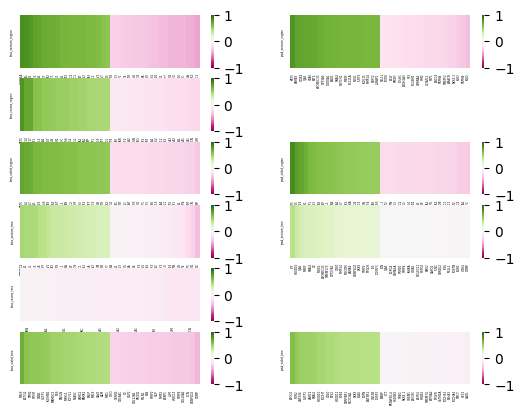

In [76]:
plot_corrs(to_gene_corr_sources, n=20)
plt.savefig(fig_dir / f'region_basal_gene_corrs.svg')

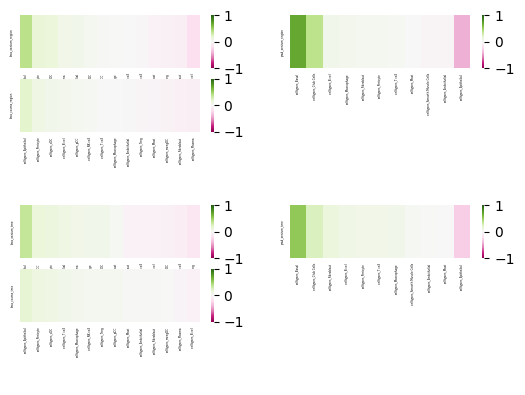

In [77]:
plot_corrs(to_ct_corr_sources, n=20)
plt.savefig(fig_dir / f'region_basal_celltype_corrs.svg')

In [49]:
for k, v in raw_corrs.items():
    disease, dtype, root = k.split('_')

    if dtype == 'xenium':
        v['dtype_ident'] = ['xenium' if len(sid_to_data[sid]['channels']) < 2000 else 'xenium5k' for sid in v['sid']]
    else:
        v['dtype_ident'] = dtype
    raw_corrs[k] = v

In [50]:
dti_to_sids = {
    'brca': {},
    'prad': {},
}
dti_to_cases = {
    'brca': {},
    'prad': {},
}
for sid, data in sid_to_data.items():
    dtype = data['df'].iloc[0]['dtype']
    case = data['df'].iloc[0]['case']
    disease = data['df'].iloc[0]['disease']
    if len(data['channels']) > 2000 and dtype == 'xenium':
        dti = 'xenium5k'
    else:
        dti = dtype

    if dti not in dti_to_sids[disease]:
        dti_to_sids[disease][dti] = set()
        dti_to_cases[disease][dti] = set()
    
    dti_to_sids[disease][dti].add(sid)
    dti_to_cases[disease][dti].add(case)

    if dti == 'xenium5k':
        dti_to_sids[disease]['xenium'].add(sid)
        dti_to_cases[disease]['xenium'].add(case)


In [51]:
dti_to_sids

{'brca': {'multiplex': {'HT206B1-U10',
   'HT206B1-U13',
   'HT206B1-U18',
   'HT206B1-U2',
   'HT206B1-U21',
   'HT206B1-U5',
   'HT339B2-H1-U2',
   'HT397B1-U12',
   'HT397B1-U2',
   'HT397B1-U22',
   'HT397B1-U31',
   'HT565B1-H2-U2',
   'HT704B1-U11',
   'HT704B1-U19',
   'HT704B1-U27',
   'HT704B1-U35',
   'HT704B1-U43',
   'HT704B1-U53',
   'HT704B1-U60',
   'HT704B1-U68',
   'HT704B1-U76',
   'HT704B1-U82',
   'HT704B1-U85',
   'HT704B1-U91'},
  'xenium': {'HT206B1-U1',
   'HT206B1-U16',
   'HT206B1-U17',
   'HT206B1-U24',
   'HT206B1-U8',
   'HT206B1-U9',
   'HT2681-Th1H3L1U2',
   'HT268B1-Th1H3L1U1',
   'HT591B1-S1H1Fp1Us1_1',
   'HT704B1-U1',
   'HT704B1-U17',
   'HT704B1-U26',
   'HT704B1-U33',
   'HT704B1-U41',
   'HT704B1-U50'},
  'cosmx': {'HT704B1-U14', 'HT704B1-U22', 'HT704B1-U47', 'HT704B1-U56'},
  'vishd': {'HT704B1-U2', 'HT704B1-U51'}},
 'prad': {'multiplex': {'HT891Z1-U103',
   'HT891Z1-U108',
   'HT891Z1-U109',
   'HT891Z1-U110',
   'HT891Z1-U111',
   'HT891Z1-U113

In [52]:
# df = raw_corrs['prad_xenium_region'].copy()
# df = df[df['dtype_ident']=='xenium5k']
# df

In [53]:
# from collections import Counter
# Counter(df['feature']).most_common()

In [54]:
dti_to_cut = {
    'xenium': .2,
    'xenium5k': .2,
    'cosmx': .2,
    'vishd': .2,
    'multiplex': .2
}

In [55]:
pval_cut = .05
root = 'region'

data = []
for key, df in raw_corrs.items():
    print(key)
    disease, dtype, root = key.split('_')
    feats = sorted(set([x for x in df['feature']]))
    feats = [x for x in feats if root in x]

    for feat in feats:
        small = df[df['feature'] == feat]
        val = small['correlation'].mean()

        m = (small['correlation'].abs() > dti_to_cut[dtype]) & (small['pvalue'] < pval_cut)
        small = small[m]
        sid_count = len(set(small['sid']))
        case_count = len(set(small['case']))
        
        direction = 'positive' if val > 0 else 'negative'
        data.append([disease, dtype, root, feat, sid_count, case_count, val, abs(val), direction])


        if dtype == 'xenium':
            small = df[df['feature'] == feat]
            small = small[small['dtype_ident'] == 'xenium5k']
            val = small['correlation'].mean()
    
            m = (small['correlation'].abs() > dti_to_cut['xenium5k']) & (small['pvalue'] < pval_cut)
            small = small[m]
            sid_count = len(set(small['sid']))
            case_count = len(set(small['case']))
            
            direction = 'positive' if val > 0 else 'negative'
            data.append([disease, 'xenium5k', root, feat, sid_count, case_count, val, abs(val), direction])
        
count_df = pd.DataFrame(data=data, columns=['disease', 'dtype', 'type', 'feature', 'sid_count', 'case_count', 'correlation', 'correlation_abs', 'direction'])
count_df


brca_multiplex_region
brca_multiplex_boundary
brca_multiplex_tme
prad_multiplex_region
prad_multiplex_boundary
prad_multiplex_tme
brca_xenium_region
brca_xenium_boundary
brca_xenium_tme
prad_xenium_region
prad_xenium_boundary
prad_xenium_tme
brca_cosmx_region
brca_cosmx_boundary
brca_cosmx_tme
prad_cosmx_region
prad_cosmx_boundary
prad_cosmx_tme
brca_vishd_region
brca_vishd_boundary
brca_vishd_tme
prad_vishd_region
prad_vishd_boundary
prad_vishd_tme


,disease,dtype,type,feature,sid_count,case_count,correlation,correlation_abs,direction
0,brca,multiplex,region,region_a-amylase,1,1,-0.100809,0.100809,negative
1,brca,multiplex,region,region_bap1,1,1,-0.077325,0.077325,negative
2,brca,multiplex,region,region_bca1,3,1,-0.072949,0.072949,negative
3,brca,multiplex,region,region_cd11b,9,3,0.098278,0.098278,positive
4,brca,multiplex,region,region_cd163,6,2,-0.022162,0.022162,negative
...,...,...,...,...,...,...,...,...,...
149603,prad,vishd,tme,tme_ZXDC,1,1,0.139415,0.139415,positive
149604,prad,vishd,tme,tme_ZYG11A,1,1,0.252774,0.252774,positive
149605,prad,vishd,tme,tme_ZYG11B,0,0,0.028538,0.028538,positive
149606,prad,vishd,tme,tme_ZYX,1,1,0.288726,0.288726,positive


In [56]:
fp = results_dir / 'counts_support.txt'
count_df.to_csv(fp, sep='\t', index=False)

In [57]:
root = 'region'
to_source = {}
for disease in ['brca', 'prad']:
    for dtype in set(count_df['dtype']):
        m = (count_df['disease']==disease) & (count_df['dtype']==dtype) & (count_df['type']==root)
        f = count_df[m]
        
        exclude = ['celltypes', 'nbhd', 'myoepithelial', 'epithelial']
        idxs = [i for i, val in zip(f.index.to_list(), f['feature']) if not len([x for x in exclude if x in val])]
        f = f.loc[idxs]
        f = f[~pd.isnull(f['correlation'])]
        f = f.sort_values(['case_count', 'sid_count', 'correlation_abs'], ascending=False)
        print(f.shape)

        for direction in ['positive', 'negative']:
            x = f[f['direction']==direction]
            print(disease, dtype, x.shape)
            x.to_csv(results_dir / f'counts_support_{disease}_{dtype}_{direction}.txt', sep='\t', index=False)

            if disease not in to_source:
                to_source[disease] = {}
            if dtype not in to_source[disease]:
                to_source[disease][dtype] = {}
            to_source[disease][dtype][direction] = x


(18047, 9)
brca vishd (12642, 9)
brca vishd (5405, 9)
(44, 9)
brca multiplex (30, 9)
brca multiplex (14, 9)
(746, 9)
brca xenium (396, 9)
brca xenium (350, 9)
(1000, 9)
brca cosmx (849, 9)
brca cosmx (151, 9)
(0, 9)
brca xenium5k (0, 9)
brca xenium5k (0, 9)
(18065, 9)
prad vishd (12718, 9)
prad vishd (5347, 9)
(26, 9)
prad multiplex (24, 9)
prad multiplex (2, 9)
(5392, 9)
prad xenium (3505, 9)
prad xenium (1887, 9)
(0, 9)
prad cosmx (0, 9)
prad cosmx (0, 9)
(5101, 9)
prad xenium5k (3266, 9)
prad xenium5k (1835, 9)


In [62]:
# dti_to_cmap = {
#     'xenium': 'oranges',
#     'xenium5k': 'teals',
#     'cosmx': 'browns',
#     'vishd': 'cividis',
#     'multiplex': 'greens'
# }


# def generate_subchart(df, key, vmax, cmap='oranges'):
#     df['x'] = key
#     a = alt.Chart(df).mark_circle(size=250).encode(
#         x=alt.X('x'),
#         y=alt.Y('feature', sort=df['feature'].to_list()),
#         color=alt.Color(key, scale=alt.Scale(scheme=cmap, domain=[0, vmax]))
#     )
    
#     b = alt.Chart(df).mark_text(baseline="middle", color='white').encode(
#         x=alt.X('x'),
#         y=alt.Y('feature', sort=df['feature'].to_list()),
#         text=alt.Text(key)
#     )
    
#     return a + b

# def generate_chart_row(source, disease, dti):
#     max_cases = len(dti_to_cases[disease][dti])
#     max_sids = len(dti_to_sids[disease][dti])
#     print(max_cases, max_sids)
    
#     cs = []
#     for k in ['sid_count', 'case_count']:
#         cs.append(generate_subchart(source,
#                                     k,
#                                     vmax=max_cases if k == 'case_count' else max_sids,
#                                     cmap=dti_to_cmap[dti]))
    
#     f = source
#     f['x'] = 'correlation'
#     a = alt.Chart(f, title=f'{disease}_{dti}').mark_rect().encode(
#         x=alt.X('x'),
#         y=alt.Y('feature', sort=f['feature'].to_list()),
#         color=alt.Color('correlation', scale=alt.Scale(scheme="pinkyellowgreen", domain=[-1, 1], reverse=False))
#     )
#     cs.append(a)
    
#     return alt.hconcat(*cs).resolve_scale(color='independent')

In [61]:
# import altair as alt
# n = 20
# s = None
# charts = []
# gene_dict = {}
# for disease, d1 in to_source.items():
#     if disease not in gene_dict:
#         gene_dict[disease] = {}
#     for dti, d2 in d1.items():
#         if dti not in gene_dict[disease]:
#             gene_dict[disease][dti] = {}
#         for direction, source in d2.items():
#             print(disease, dti, source.shape)
            
#             if source.shape[0]:
#                 s = source.iloc[:n].copy()
#                 s['feature'] = [x.replace('region_', '') for x in s['feature']]
#                 charts.append(generate_chart_row(s, disease, dti))
#                 gene_dict[disease][dti][direction] = s['feature'].to_list()
                
#             else:
#                 print(f'{disease} {dti} is missing')
                

# alt.vconcat(*charts).resolve_scale(color='independent', x='independent', y='independent')

In [58]:
dti_to_sid_order = {}
for disease, d1 in dti_to_sids.items():
    if disease not in dti_to_sid_order:
        dti_to_sid_order[disease] = {}
    for dti, sids in d1.items():
        tups = []
        for sid in sids:
            x1 = re.sub(r'^(.*)[-_]U([0-9]+)$', r'\1', sid)
            x2 = re.sub(r'^.*U([0-9]+)$', r'\1', sid)
            try:
                x2 = int(x2)
            except:
                pass
            tups.append((x1, x2, sid))
        tups = sorted(tups)
        sids = [sid for _, _, sid in tups]
        dti_to_sid_order[disease][dti] = sids

sid_order = []
for disease in ['brca', 'prad']:
    for dti in ['xenium', 'xenium5k', 'cosmx', 'vishd']:
        sid_order += [x for x in dti_to_sid_order[disease].get(dti, [])
                      if not (dti == 'xenium' and x in dti_to_sids['prad']['xenium5k'])]
sid_order

['HT206B1-U1',
 'HT206B1-U8',
 'HT206B1-U9',
 'HT206B1-U16',
 'HT206B1-U17',
 'HT206B1-U24',
 'HT2681-Th1H3L1U2',
 'HT268B1-Th1H3L1U1',
 'HT591B1-S1H1Fp1Us1_1',
 'HT704B1-U1',
 'HT704B1-U17',
 'HT704B1-U26',
 'HT704B1-U33',
 'HT704B1-U41',
 'HT704B1-U50',
 'HT704B1-U14',
 'HT704B1-U22',
 'HT704B1-U47',
 'HT704B1-U56',
 'HT704B1-U2',
 'HT704B1-U51',
 'HT814Z1-S1H1Fp1Us1_3',
 'HT817Z1-S1H1Fp1Us1_2',
 'HT832Z1-S1H1Fp1U1',
 'HT849Z1-S1H2Fp1U1',
 'HT852Z1-S1H1Fp1U1',
 'HT891Z1-U1',
 'HT891Z1-U21',
 'HT891Z1-U31',
 'HT891Z1-U44',
 'HT891Z1-U59',
 'HT891Z1-U69',
 'HT891Z1-U81',
 'HT891Z1-U94',
 'HT891Z1-U104',
 'HT913Z1-U33',
 'HT913Z1-U34',
 'HT913Z1-U35',
 'HT913Z1-U61',
 'HT913Z1-U81',
 'HT913Z1-U101',
 'S18-11798-A15Us1_1',
 'S18-15142-B17Us2_1',
 'S18-15142Fp1Us1_1',
 'S18-18215-A25Us1_1',
 'S18-5591-C8-U1',
 'S18-5591-C8-U5',
 'S18-5591-C8-U7',
 'S18-5591-C8-U12',
 'S18-5591-C8-U18',
 'S18-5591-C8-U20',
 'S18-5591-C8Us1_1',
 'S18-8795-A10Us2_1',
 'S18-9251-F15U1',
 'S18-9259-B14U1',
 'S

In [59]:
dti_to_sid_order

{'brca': {'multiplex': ['HT206B1-U2',
   'HT206B1-U5',
   'HT206B1-U10',
   'HT206B1-U13',
   'HT206B1-U18',
   'HT206B1-U21',
   'HT339B2-H1-U2',
   'HT397B1-U2',
   'HT397B1-U12',
   'HT397B1-U22',
   'HT397B1-U31',
   'HT565B1-H2-U2',
   'HT704B1-U11',
   'HT704B1-U19',
   'HT704B1-U27',
   'HT704B1-U35',
   'HT704B1-U43',
   'HT704B1-U53',
   'HT704B1-U60',
   'HT704B1-U68',
   'HT704B1-U76',
   'HT704B1-U82',
   'HT704B1-U85',
   'HT704B1-U91'],
  'xenium': ['HT206B1-U1',
   'HT206B1-U8',
   'HT206B1-U9',
   'HT206B1-U16',
   'HT206B1-U17',
   'HT206B1-U24',
   'HT2681-Th1H3L1U2',
   'HT268B1-Th1H3L1U1',
   'HT591B1-S1H1Fp1Us1_1',
   'HT704B1-U1',
   'HT704B1-U17',
   'HT704B1-U26',
   'HT704B1-U33',
   'HT704B1-U41',
   'HT704B1-U50'],
  'cosmx': ['HT704B1-U14', 'HT704B1-U22', 'HT704B1-U47', 'HT704B1-U56'],
  'vishd': ['HT704B1-U2', 'HT704B1-U51']},
 'prad': {'multiplex': ['HT891Z1-U14',
   'HT891Z1-U32',
   'HT891Z1-U40',
   'HT891Z1-U41',
   'HT891Z1-U43',
   'HT891Z1-U45',
   

In [68]:
to_source['prad']['xenium']['positive']

,disease,dtype,type,feature,sid_count,case_count,correlation,correlation_abs,direction
10704,prad,xenium,region,region_KRT5,41,23,0.673261,0.673261,positive
12028,prad,xenium,region,region_NTN4,45,22,0.513263,0.513263,positive
8884,prad,xenium,region,region_FHL2,44,21,0.448322,0.448322,positive
8252,prad,xenium,region,region_DST,43,20,0.488072,0.488072,positive
15312,prad,xenium,region,region_TP63,27,20,0.479087,0.479087,positive
...,...,...,...,...,...,...,...,...,...
5510,prad,xenium,region,region_ADCY2,0,0,0.000075,0.000075,positive
10602,prad,xenium,region,region_KLF16,0,0,0.000071,0.000071,positive
7798,prad,xenium,region,region_CUL4B,0,0,0.000035,0.000035,positive
15080,prad,xenium,region,region_TLR4,0,0,0.000006,0.000006,positive


In [71]:
to_gene_corr_sources = {}
for disease, d1 in to_source.items():
    to_gene_corr_sources[disease] = {}
    for dti, d2 in d1.items():
        dtype = dti.replace('5k', '')
        f = raw_corrs[f'{disease}_{dtype}_region'].copy()
        f = f[f['dtype_ident']==dti]
        f.index = [x.replace('region_', '') + '_' + y  for x, y in f[['feature', 'sid']].values]
        assert len(set(f.index.to_list())) == f.shape[0]
        for direction, x in d2.items():
            feats = [z.replace('region_', '') for z in x['feature']]
            if dti in dti_to_sids[disease]:
                data = []
                for feat in feats:
                    for sid in dti_to_sid_order[disease][dti]:
                        if f'{feat}_{sid}' in f.index:
                            val = f.loc[f'{feat}_{sid}', 'correlation']
                        else:
                            val = np.nan
                        data.append([feat, sid, val])
                source = pd.DataFrame(data=data, columns=['feature', 'sid', 'correlation'])
                source = source.pivot(columns='sid', index='feature')
                source.columns = [x for _, x in source.columns]
                source = source[dti_to_sid_order[disease][dti]]
                source = source.loc[feats]

                if dti not in to_gene_corr_sources[disease]:
                    to_gene_corr_sources[disease][dti] = {}
                to_gene_corr_sources[disease][dti][direction] = source

                source.to_csv(results_dir / f'corr_by_sid_{disease}_{dti}_{direction}.txt', sep='\t')
                
            

In [72]:
to_gene_corr_sources['prad']['xenium']['positive']


,HT814Z1-S1H1Fp1Us1_3,HT817Z1-S1H1Fp1Us1_2,HT832Z1-S1H1Fp1U1,HT832Z1U1,HT849Z1-S1H2Fp1U1,HT852Z1-S1H1Fp1U1,HT891Z1-U1,HT891Z1-U21,HT891Z1-U31,HT891Z1-U44,...,S18-9906-U2,S18-9906-U9,S18-9906-U17,S18-9906-U24,S19-41530-D1U3,S20-12521-A15U1,S21-11816-A2U3,S21-44455-A1U3,S22-44238-A29U1,S22-53426-A1U3
feature,,,,,,,,,,,,,,,,,,,,,
KRT5,0.473656,0.719010,0.799574,NaN,0.393028,0.733713,0.940574,0.730510,0.726969,0.751897,...,NaN,NaN,NaN,NaN,0.522878,0.406304,0.500542,0.203351,0.597316,0.437132
NTN4,0.394198,0.431129,0.734952,NaN,0.301078,0.602173,0.550893,0.756384,0.694813,0.552739,...,0.761492,0.747661,0.594069,0.643068,0.296920,0.501034,0.631485,0.113945,0.464041,-0.049579
FHL2,0.372128,0.338434,0.665484,NaN,0.315945,0.501838,0.588548,0.659837,0.582957,0.510322,...,0.715311,0.728653,0.591208,0.644493,0.067595,0.438708,0.488760,0.228507,-0.007792,0.200975
DST,0.143141,0.498359,0.650029,NaN,0.414494,0.680459,0.727226,0.684587,0.606316,0.500748,...,0.691818,0.578789,0.627789,0.636762,-0.205079,0.466870,0.433489,-0.003129,0.396861,-0.039529
TP63,0.735240,0.573611,0.726574,NaN,0.351877,0.560848,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.476303,0.477779,0.599950,0.103599,0.400485,-0.038792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ADCY2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KLF16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CUL4B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# fig, axs = plt.subplots(nrows=16, figsize=(20, 80))
# i = 0
# for disease, d1 in to_gene_corr_sources.items():
#     for dti, d2 in d1.items():
#         for direction, source in d2.items():
#             ax = axs[i]
#             if direction == 'positive':
#                 X = source.values.copy()
#                 X[pd.isnull(X)] = 0
#                 vmin = 0
#                 vmax = X.max()
#                 cmap = 'Greens'
#             else:
#                 X = source.values.copy()
#                 X[pd.isnull(X)] = 0
#                 vmin = X.min()
#                 vmax = 0
#                 cmap = 'RdPu_r'
#             sns.heatmap(source, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
#             ax.set_ylabel(f'{disease}_{dti}_{direction}')
#             ax.set_facecolor('lightgray')
#             i += 1
# plt.savefig(fig_dir / f'dti_specific_correlation_heatmaps.svg')

In [73]:
denoms = {}
for disease, d1 in dti_to_sids.items():
    for dti, sids in d1.items():
        if dti != 'multiplex':
            counts = []
            for sid in sids:
                channels = sorted(set(sid_to_data[sid]['channels']))
                counts.append(len(channels))
            denoms[dti] = int(np.max(counts))
denoms

{'xenium': 5101, 'cosmx': 1000, 'vishd': 18085, 'xenium5k': 5101}

In [74]:
dti_to_all_channels = {}
for dti in ['xenium', 'xenium5k', 'cosmx', 'vishd']:
    channels = sorted(set.union(*[set(sid_to_data[sid]['channels'])
                         for disease, d1 in dti_to_sids.items()
                         for sid in d1.get(dti, [])]))
    dti_to_all_channels[dti] = channels
    print(dti, len(channels))

xenium 5471
xenium5k 5101
cosmx 1000
vishd 18085


In [75]:

data = []
for disease, d1 in to_source.items():
    for dti, d2 in d1.items():
        for direction, df in d2.items():
            df = df.set_index('feature')
            df.index = [x.replace('region_', '') for x in df.index]
            for feat, row in df.iterrows():
                if dti == 'multiplex':
                    pass
                else:
                    data.append([
                        disease,
                        dti,
                        feat,
                        row['sid_count'],
                        row['case_count'],
                        row['correlation'],
                        row['correlation_abs'],
                        row['direction'],
                        df.index.to_list().index(feat),
                        df.index.to_list().index(feat) / denoms[dti]
                    ])
df = pd.DataFrame(data=data, columns=['disease', 'dtype_ident', 'feature', 'sid_count', 'case_count', 'correlation', 'correlation_abs', 'direction', 'rank', 'rank_pct'])
df = df[df['dtype_ident']!='multiplex']
df.index = [f'{x}_{y}_{z}_{zz}' for x, y, z, zz in df[['disease', 'dtype_ident', 'feature', 'direction']].values]
df


,disease,dtype_ident,feature,sid_count,case_count,correlation,correlation_abs,direction,rank,rank_pct
brca_vishd_KRT5_positive,brca,vishd,KRT5,2,1,0.705467,0.705467,positive,0,0.000000
brca_vishd_KRT14_positive,brca,vishd,KRT14,2,1,0.686850,0.686850,positive,1,0.000055
brca_vishd_KRT17_positive,brca,vishd,KRT17,2,1,0.664934,0.664934,positive,2,0.000111
brca_vishd_COL17A1_positive,brca,vishd,COL17A1,2,1,0.621373,0.621373,positive,3,0.000166
brca_vishd_TRIM29_positive,brca,vishd,TRIM29,2,1,0.615987,0.615987,positive,4,0.000221
...,...,...,...,...,...,...,...,...,...,...
prad_xenium5k_WDR12_negative,prad,xenium5k,WDR12,0,0,-0.000078,0.000078,negative,1830,0.358753
prad_xenium5k_RHD_negative,prad,xenium5k,RHD,0,0,-0.000070,0.000070,negative,1831,0.358949
prad_xenium5k_MSC_negative,prad,xenium5k,MSC,0,0,-0.000021,0.000021,negative,1832,0.359145
prad_xenium5k_PTGFR_negative,prad,xenium5k,PTGFR,0,0,-0.000019,0.000019,negative,1833,0.359341


In [76]:
# df[df['feature']=='KRT5']

In [77]:
# grouped[grouped['feature']=='KRT5']

In [78]:
# grouped_counts[grouped_counts['feature']=='KRT5']

In [79]:
grouped = df[['disease', 'feature', 'correlation', 'rank', 'rank_pct', 'direction']].groupby(
    ['disease', 'feature', 'direction']).mean()
grouped = grouped.reset_index()
grouped

,disease,feature,direction,correlation,rank,rank_pct
0,brca,A1CF,positive,0.094974,3071.000000,0.169809
1,brca,A2M,positive,0.490572,36.000000,0.001991
2,brca,A2ML1,positive,0.064113,5108.000000,0.282444
3,brca,A3GALT2,positive,0.042556,7241.000000,0.400387
4,brca,A4GALT,positive,0.106730,2583.000000,0.142826
...,...,...,...,...,...,...
38604,prad,ZYG11A,positive,0.016238,11009.000000,0.608737
38605,prad,ZYG11B,positive,0.017108,5514.333333,0.551404
38606,prad,ZYX,positive,0.180544,788.666667,0.114451
38607,prad,ZZEF1,positive,0.030487,9753.000000,0.539287


In [80]:
grouped_counts = df[['disease', 'feature', 'correlation', 'direction']].groupby(
    ['disease', 'feature', 'direction']).count()
grouped['count'] = grouped_counts['correlation'].to_list()
for dti in ['xenium', 'xenium5k', 'cosmx', 'vishd']:
    for col in ['rank', 'sid_count', 'case_count', 'correlation']:
        grouped[f'{dti}_{col}'] = [df.loc[f'{x}_{dti}_{y}_{z}', col] if f'{x}_{dti}_{y}_{z}' in df.index else np.nan
                                  for x, y, z in grouped[['disease', 'feature', 'direction']].values]
grouped

,disease,feature,direction,correlation,rank,rank_pct,count,xenium_rank,xenium_sid_count,xenium_case_count,...,xenium5k_case_count,xenium5k_correlation,cosmx_rank,cosmx_sid_count,cosmx_case_count,cosmx_correlation,vishd_rank,vishd_sid_count,vishd_case_count,vishd_correlation
0,brca,A1CF,positive,0.094974,3071.000000,0.169809,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3071.0,0.0,0.0,0.094974
1,brca,A2M,positive,0.490572,36.000000,0.001991,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,36.0,2.0,1.0,0.490572
2,brca,A2ML1,positive,0.064113,5108.000000,0.282444,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5108.0,0.0,0.0,0.064113
3,brca,A3GALT2,positive,0.042556,7241.000000,0.400387,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7241.0,0.0,0.0,0.042556
4,brca,A4GALT,positive,0.106730,2583.000000,0.142826,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2583.0,0.0,0.0,0.106730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38604,prad,ZYG11A,positive,0.016238,11009.000000,0.608737,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11009.0,0.0,0.0,0.016238
38605,prad,ZYG11B,positive,0.017108,5514.333333,0.551404,3,2733.0,0.0,0.0,...,0.0,0.018872,NaN,NaN,NaN,NaN,11289.0,0.0,0.0,0.013582
38606,prad,ZYX,positive,0.180544,788.666667,0.114451,3,876.0,1.0,1.0,...,1.0,0.111076,NaN,NaN,NaN,NaN,856.0,1.0,1.0,0.319480
38607,prad,ZZEF1,positive,0.030487,9753.000000,0.539287,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9753.0,0.0,0.0,0.030487


In [81]:
to_consensus = {}
for disease in ['brca', 'prad']:
    to_consensus[disease] = {}
    for direction in ['positive', 'negative']:
        m = (grouped['disease']==disease) & (grouped['direction']==direction) & (grouped['count'] >= 2)
        source = grouped[m].sort_values('rank_pct')
        
        fp = results_dir / f'disease_specific_consensus_features_{disease}_{direction}.txt'
        source.to_csv(fp, sep='\t', index=False)

        to_consensus[disease][direction] = source



In [82]:
to_consensus['brca']['negative']

,disease,feature,direction,correlation,rank,rank_pct,count,xenium_rank,xenium_sid_count,xenium_case_count,...,xenium5k_case_count,xenium5k_correlation,cosmx_rank,cosmx_sid_count,cosmx_case_count,cosmx_correlation,vishd_rank,vishd_sid_count,vishd_case_count,vishd_correlation
4204,brca,DCN,negative,-0.245742,1.0,0.000528,2,NaN,NaN,NaN,...,NaN,NaN,1.0,2.0,1.0,-0.217758,1.0,1.0,1.0,-0.273726
9028,brca,LUM,negative,-0.241999,2.0,0.001055,2,NaN,NaN,NaN,...,NaN,NaN,2.0,2.0,1.0,-0.215198,2.0,1.0,1.0,-0.268800
3558,brca,COL1A1,negative,-0.202623,24.5,0.001355,2,NaN,NaN,NaN,...,NaN,NaN,0.0,3.0,1.0,-0.224255,49.0,1.0,1.0,-0.180991
3943,brca,CTSK,negative,-0.154709,12.0,0.001649,2,14.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,1.0,-0.233709
14267,brca,SFRP2,negative,-0.119558,15.5,0.002053,2,17.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,1.0,1.0,-0.222925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4056,brca,CYP1A1,negative,-0.018435,2773.5,0.164760,2,162.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5385.0,0.0,0.0,-0.000162
9686,brca,MMP9,negative,-0.012642,2094.0,0.170107,2,NaN,NaN,NaN,...,NaN,NaN,115.0,0.0,0.0,-0.013902,4073.0,0.0,0.0,-0.011382
5248,brca,ESR1,negative,-0.013166,2196.0,0.173385,2,NaN,NaN,NaN,...,NaN,NaN,110.0,0.0,0.0,-0.016824,4282.0,0.0,0.0,-0.009508
11683,brca,PDCD1,negative,-0.004344,2800.5,0.178075,2,330.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5271.0,0.0,0.0,-0.001037


In [83]:
# def generate_consensus_chart(disease, direction, n=20):
#     source = to_consensus[disease][direction].iloc[:20]
    
#     a = alt.Chart(source, title=f'{disease}_{direction}').mark_rect().encode(
#         y=alt.Y('feature', sort=source['feature'].to_list()),
#         color=alt.Color('rank_pct', scale=alt.Scale(scheme="viridis", domain=[0, .015], reverse=True))
#     )

#     cols = ['xenium_rank', 'xenium5k_rank', 'cosmx_rank', 'vishd_rank']
#     melted = source.melt(id_vars=['disease', 'feature'], value_vars=cols)

#     dti_to_color = {
#         'xenium': 'darkorange',
#         'xenium5k': 'teal',
#         'cosmx': 'brown',
#         'vishd': 'gold'
#     }
#     cs = []
#     for x in cols:
#         f = melted[melted['variable']==x]
    
#         b = alt.Chart(f, title=x).mark_rect(color=dti_to_color[x.split('_')[0]], strokeWidth=1, stroke='lightgray').encode(
#             y=alt.Y('feature', sort=source['feature'].to_list()),
#             # color=alt.Color('variable', scale=alt.Scale()),
#         )
        
#         c = alt.Chart(f).mark_text(baseline="middle", color='white').encode(
#             y=alt.Y('feature', sort=source['feature'].to_list()),
#             text=alt.Text('value'),
#         )
    
#         cs.append(b + c)
#     aa = alt.hconcat(*cs).resolve_scale(color='independent', x='independent', y='independent')

#     return alt.hconcat(a, aa).resolve_scale(color='independent', x='independent', y='independent')


In [84]:
# disease, direction = 'brca', 'positive'
# generate_consensus_chart(disease, direction)

In [85]:
# disease, direction = 'brca', 'negative'
# generate_consensus_chart(disease, direction)

In [86]:
# disease, direction = 'prad', 'positive'
# generate_consensus_chart(disease, direction)

In [87]:
# disease, direction = 'prad', 'negative'
# generate_consensus_chart(disease, direction)

In [93]:
to_gene_consensus_corr_sources = {}
for disease, d1 in to_consensus.items():
    to_gene_consensus_corr_sources[disease] = {}
    for direction, f in d1.items():
        feats = f['feature'].to_list()

        combined = []
        for dti in ['xenium', 'xenium5k', 'cosmx', 'vishd']:
            dtype = dti.replace('5k', '')
            f = raw_corrs[f'{disease}_{dtype}_region'].copy()
            f = f[f['dtype_ident']==dti]
            f.index = [x.replace('region_', '') + '_' + y  for x, y in f[['feature', 'sid']].values]
            combined.append(f)
        combined = pd.concat(combined)

        
        data = []
        for feat in feats:
            for sid in sid_order:
                if f'{feat}_{sid}' in combined.index:
                    val = combined.loc[f'{feat}_{sid}', 'correlation']
                else:
                    val = np.nan
                data.append([feat, sid, val])

        source = pd.DataFrame(data=data, columns=['feature', 'sid', 'correlation'])
        source = source.pivot(columns='sid', index='feature')
        source.columns = [x for _, x in source.columns]
        source = source[sid_order]
        source = source.loc[feats]

        to_gene_consensus_corr_sources[disease][direction] = source

        source.to_csv(results_dir / f'consensus_corr_by_sid_{disease}_{direction}.txt', sep='\t')

/tmp/ipykernel_2014688/1559885733.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(combined)
/tmp/ipykernel_2014688/1559885733.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(combined)


In [89]:
# fig, axs = plt.subplots(nrows=4, figsize=(20, 30))
# i = 0
# for disease, d1 in to_gene_consensus_corr_sources.items():
#     for direction, source in d1.items():
#         ax = axs[i]
#         if direction == 'positive':
#             X = source.values.copy()
#             X[pd.isnull(X)] = 0
#             vmin = 0
#             vmax = X.max()
#             cmap = 'Greens'
#         else:
#             X = source.values.copy()
#             X[pd.isnull(X)] = 0
#             vmin = X.min()
#             vmax = 0
#             cmap = 'RdPu_r'
#         sns.heatmap(source, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
#         ax.set_ylabel(f'{disease}_{direction}')
#         ax.set_facecolor('lightgray')
#         i += 1
# plt.savefig(fig_dir / f'consensus_correlation_heatmaps.svg')

In [112]:
to_source['prad']['xenium']['positive']

,disease,dtype,type,feature,sid_count,case_count,correlation,correlation_abs,direction
10704,prad,xenium,region,region_KRT5,41,23,0.673261,0.673261,positive
12028,prad,xenium,region,region_NTN4,45,22,0.513263,0.513263,positive
8884,prad,xenium,region,region_FHL2,44,21,0.448322,0.448322,positive
8252,prad,xenium,region,region_DST,43,20,0.488072,0.488072,positive
15312,prad,xenium,region,region_TP63,27,20,0.479087,0.479087,positive
...,...,...,...,...,...,...,...,...,...
5510,prad,xenium,region,region_ADCY2,0,0,0.000075,0.000075,positive
10602,prad,xenium,region,region_KLF16,0,0,0.000071,0.000071,positive
7798,prad,xenium,region,region_CUL4B,0,0,0.000035,0.000035,positive
15080,prad,xenium,region,region_TLR4,0,0,0.000006,0.000006,positive


In [124]:
gene_lists = {
    'brca_positive': [],
    'brca_negative': [],
    'prad_positive': [],
    'prad_negative': [],
    'combined_positive': [],
    'combined_negative': [],
}

In [125]:
n = 200

for disease, d1 in to_gene_corr_sources.items():
    for dti, d2 in d1.items():
        for direction, f in d2.items():
            key = f'{disease}_{direction}'
            if f.shape[0]:
                print('a', f.index.to_list()[0])
                gene_lists[key] += f.index.to_list()[:n]

for disease, d1 in to_source.items():
    for dti, d2 in d1.items():
        for direction, f in d2.items():
            key = f'{disease}_{direction}'
            if f.shape[0]:
                # print('b', f.index.to_list()[0])
                feats = [x.replace('region_', '') for x in f['feature']]
                gene_lists[key] += feats[:n]

for disease, d1 in to_gene_consensus_corr_sources.items():
    for direction, f in d1.items():
        key = f'{disease}_{direction}'
        if f.shape[0]:
            print('c', f.index.to_list()[0])
            gene_lists[key] += f.index.to_list()[:n]



for k, v in gene_lists.items():
    print(k, len(set(v)))

# diseases = ['brca', 'prad']
# dtypes = ['xenium', 'cosmx', 'vishd']
# idents = ['region', 'tme']
# exclude = ['celltypes', 'nbhd', 'myoepithelial', 'epithelial']
# tups = [(ident, dtype) for ident in idents for dtype in dtypes]
# for i, disease in enumerate(diseases):
#     for j, dtype in enumerate(dtypes):
#         for k, ident in enumerate(idents):
#             df = corr_dfs[f'{disease}_{dtype}_{ident}']
#             idxs = [i for i in df.index.to_list() if not len([x for x in exclude if x in i])]
#             source = df.loc[idxs]
#             source = source[~pd.isnull(source['correlation'])]
#             if source.shape[0]:
#                 if n * 2 < source.shape[0]:
#                     source = pd.concat((source.iloc[:n], source.iloc[-n:]))
#                 source = source.sort_values('correlation', ascending=False)
#                 source.index = [c.replace(f'region_', '').replace('tme_', '') for c in source.index.to_list()]

#                 for feat, corr in zip(source.index.to_list(), source['correlation']):
#                     if corr > 0:
#                         gene_lists[f'{disease}_positive'].append(feat)
#                     else:
#                         gene_lists[f'{disease}_negative'].append(feat)

# for k, v in gene_lists.items():
#     print(k, len(set(v)))

a KRT5
a COMP
a ck14
a pr
a MYLK
a KRT7
a KRT5
a COL1A1
a KRT5
a TMEFF2
a ck5
a amacr
a KRT5
a ALDH1A3
a TP63
a ANPEP
c MYLK
c DCN
c NTN4
c ALDH1A3
brca_positive 543
brca_negative 516
prad_positive 548
prad_negative 416
combined_positive 0
combined_negative 0


In [126]:

a = set(gene_lists['brca_positive'])
b = set(gene_lists['prad_positive'])
common = a.intersection(b)

a -= common
b -= common
c = set(gene_lists['combined_positive'])
d = set.union(common, c)

gene_lists['brca_positive'] = sorted(a)
gene_lists['prad_positive'] = sorted(b)
gene_lists['combined_positive'] = sorted(d)

a = set(gene_lists['brca_negative'])
b = set(gene_lists['prad_negative'])
common = a.intersection(b)

a -= common
b -= common
c = set(gene_lists['combined_negative'])
d = set.union(common, c)

gene_lists['brca_negative'] = sorted(a)
gene_lists['prad_negative'] = sorted(b)
gene_lists['combined_negative'] = sorted(d)

for k, v in gene_lists.items():
    print(k, len(set(v)))

brca_positive 342
brca_negative 449
prad_positive 347
prad_negative 349
combined_positive 201
combined_negative 67


In [120]:
for k, v in gene_lists.items():
    print(k)
    for x in v:
        print(x)

    print()
    print()
    print()

brca_positive
ACACB
ACTA2
ACTN1
ACVR2A
ADAMTS1
ADGRE1
ADGRG1
ADGRL2
AIF1L
ALDH1A3
ANKRD1
ANPEP
ANXA3
APOC1
APOE
APP
AQP4
AR
AREG
ARFGEF3
ARID5A
ARID5B
ATL2
B2M
BAMBI
BARX2
BCAM
BHLHE41
C1QB
C1QC
C5AR1
CA9
CACHD1
CACNA1C
CALD1
CALML3
CARMN
CCDC8
CCDC9B
CCL28
CCN3
CCND1
CD247
CD38
CD3D
CD53
CD59
CD81
CD83
CD86
CDH1
CDH13
CFAP53
CHI3L1
CHST9
CLDN11
CLDN4
CLIP4
CMTM7
CNN1
COL16A1
COL27A1
COL4A2
COL9A3
COTL1
CRABP1
CRYAB
CRYBG1
CSPG4
CSRP1
CSTB
CTNNB1
CTSD
CXCL1/2/3
CXCL16
CYTOR
DEPP1
DLGAP1
DLL1
DMD
DPT
DSC2
DSG3
DUSP6
ECRG4
EDNRB
EGR1
EHD3
EIF5A/L1
ENO1
EOGT
EPHB3
ESR1
ETS1
ETV4
ETV5
FABP7
FAM20C
FAT1
FBXO32
FCGR1A
FCGR3A
FGF1
FGF2
FMO2
FOXA1
FOXC1
FOXC2
FOXI1
FXYD2
FZD7
FZD8
GCG
GPC3
GPNMB
GPX1
GSN
GUCY1A1
GZMH
H2AFY2
HEMGN
HLA-DPA1
HLA-DPB1
HPX
ID4
IFFO2
IFIT2
IFNAR2
IFNG
IFNGR1
IGFBP3
IGFBP5
IL17RD
IL34
IL6
INSR
IRS2
IRX1
IRX2
IRX4
ITGA9
ITGB1
ITGB2
ITGB3
ITPR2
ITPRID2
KCNMB1
KLHL21
KLK10
KLK5
KLK6
KLK7
KLK8
KLRB1
KNG1
KRT16
KRT20
KRT6A/B/C
KRT6B
KRT86
LAD1
LAMP2
LDHB
LGI4
LGR4
LGR5
LI

In [114]:
def get_consensus_twinned(direction):

    df1 = to_consensus['brca'][direction]
    df2 = to_consensus['prad'][direction]
    shared = sorted(set(df1['feature']).intersection(set(df2['feature'])))
    
    df1 = df1.set_index('feature')
    df2 = df2.set_index('feature')
    
    df1 = df1.loc[shared]
    df2 = df2.loc[shared]
    
    new = pd.DataFrame.from_dict({
        'feature': shared,
        'rank_pct_brca': df1['rank_pct'],
        'rank_pct_prad': df2['rank_pct'],
    })
    
    new = new[((new['rank_pct_brca'] < 1.) & (new['rank_pct_prad'] < 1.))]

    return new

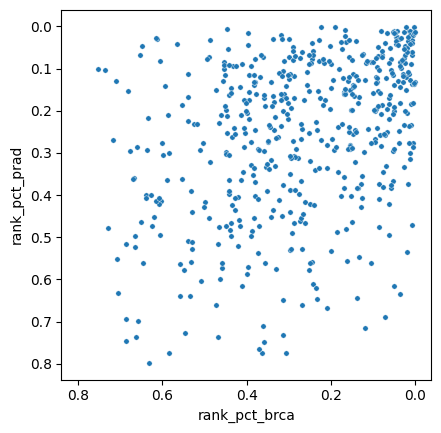

In [115]:
new = get_consensus_twinned('positive')

sns.scatterplot(data=new, x='rank_pct_brca', y='rank_pct_prad', s=15)
plt.axis('square')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.savefig(fig_dir / 'consensus_scatterplot_all_positive.svg')

In [116]:
f = new.copy()
f['score'] = (1 - f['rank_pct_brca']) * (1 - f['rank_pct_prad'])
f = f[f['rank_pct_brca'] < .05]
f = f[f['rank_pct_prad'] < .05]
for g in f.sort_values('score', ascending=False).index.to_list():
    print(g)

DST
TNC
COL17A1
LTBP2
TP63
FGL2
KRT5
CAVIN1
ITGB4
GAS6
EGFR
ITGB6
ITGA2
CAV1
GLIPR1
ITGA3
PLAT
VIM
CLCA2
MS4A6A
MGP
EHF
CX3CL1
NOTCH1
SPI1
CFTR


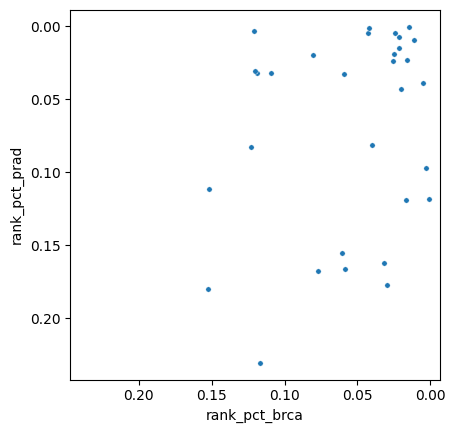

In [117]:
new = get_consensus_twinned('negative')

sns.scatterplot(data=new, x='rank_pct_brca', y='rank_pct_prad', s=15)
plt.axis('square')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.savefig(fig_dir / 'consensus_scatterplot_all_negative.svg')

In [118]:
f = new.copy()
f['score'] = (1 - f['rank_pct_brca']) * (1 - f['rank_pct_prad'])
f = f[f['rank_pct_brca'] < .05]
f = f[f['rank_pct_prad'] < .05]
for g in f.sort_values('score', ascending=False).index.to_list():
    print(g)

MYBPC1
FASN
FBP1
STEAP1
ALCAM
CCDC78
GLYATL1
AR
SCD
EPHA6
LDLR
XBP1


In [119]:
corr_dfs.keys()

dict_keys(['brca_multiplex_region', 'brca_multiplex_boundary', 'brca_multiplex_tme', 'prad_multiplex_region', 'prad_multiplex_boundary', 'prad_multiplex_tme', 'brca_xenium_region', 'brca_xenium_boundary', 'brca_xenium_tme', 'prad_xenium_region', 'prad_xenium_boundary', 'prad_xenium_tme', 'brca_cosmx_region', 'brca_cosmx_boundary', 'brca_cosmx_tme', 'prad_cosmx_region', 'prad_cosmx_boundary', 'prad_cosmx_tme', 'brca_vishd_region', 'brca_vishd_boundary', 'brca_vishd_tme', 'prad_vishd_region', 'prad_vishd_boundary', 'prad_vishd_tme'])

In [120]:
f = None
v = None
disease_to_dtype_to_df = {}
for k, v in corr_dfs.items():
    disease, dtype, rtype = k.split('_')

    if rtype == 'region':
        exclude = ['celltypes', 'nbhd', 'myoepithelial', 'epithelial']
        idxs = [i for i in v.index.to_list() if not len([x for x in exclude if x in i])]
        f = v.loc[idxs]
        f = f[~pd.isnull(f['correlation'])]
        f.index = [x.replace('region_', '') for x in f.index.to_list()]

        if disease not in disease_to_dtype_to_df:
            disease_to_dtype_to_df[disease] = {}
        disease_to_dtype_to_df[disease][dtype] = f


In [121]:
disease_to_dtype_to_df['prad']['xenium']

,correlation,pvalue
KLK2,-0.361756,1.115494e-03
TRPM8,-0.317642,1.859622e-01
KLK3,-0.304682,5.622084e-02
NKX3-1,-0.270167,6.904089e-03
AMACR,-0.263292,2.586785e-02
...,...,...
CPA6,0.690171,2.529907e-02
GJA1,0.698063,2.230048e-09
ITGB4,0.704617,2.155508e-02
LAMB3,0.713547,7.823572e-06


In [122]:
dtype_to_df = {}
for dtype in ['xenium', 'vishd']:
    df1 = disease_to_dtype_to_df['brca'][dtype]
    df2 = disease_to_dtype_to_df['prad'][dtype]
    shared = sorted(set(df1.index.to_list()).intersection(set(df2.index.to_list())))
    
    df1 = df1.loc[shared]
    df2 = df2.loc[shared]
    
    new = pd.DataFrame.from_dict({
        'feature': shared,
        'corr_brca': df1['correlation'],
        'corr_prad': df2['correlation'],
    })
    
    dtype_to_df[dtype] = new


In [123]:
dtype_to_df['xenium']

,feature,corr_brca,corr_prad
ABCC11,ABCC11,-0.152185,0.006416
ACAN,ACAN,-0.084902,-0.028095
ACE2,ACE2,0.095140,0.128072
ACKR1,ACKR1,0.033729,0.026844
ACTA2,ACTA2,0.671197,0.040911
...,...,...,...
VIM,VIM,0.436127,0.098713
VPREB1,VPREB1,-0.026871,0.025934
VSIG4,VSIG4,0.157640,0.130123
VWA5A,VWA5A,0.464407,0.458400


In [124]:
gene_lists = {
    'brca_positive': [],
    'brca_negative': [],
    'prad_positive': [],
    'prad_negative': [],
    'combined_positive': [],
    'combined_negative': [],
}

(-0.519249379913608,
 0.8717922383557315,
 -0.41917477335196435,
 0.9718668449173751)

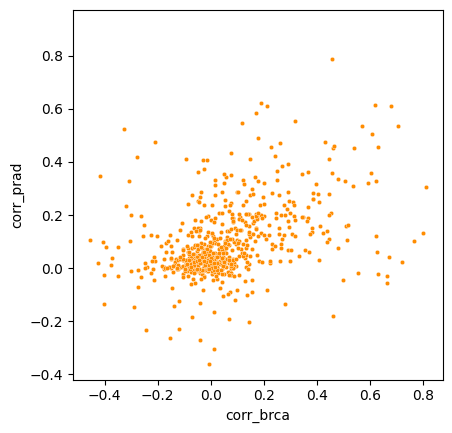

In [125]:
sns.scatterplot(data=dtype_to_df['xenium'], x='corr_brca', y='corr_prad', c='darkorange', s=10)
plt.axis('square')

In [126]:
f = dtype_to_df['xenium'].copy()
f['score'] = f['corr_brca'] * f['corr_prad']


In [127]:
x = f[f['corr_brca'] > .3]
x = x[x['corr_prad'] > .3]
genes = x.sort_values('score', ascending=False).index.to_list()
gene_lists['combined_positive'] += genes
for g in genes: print(g)

DST
TP63
COL17A1
KRT5
GATA3
KRT17
LTBP2
SCNN1A
MET
LAMC2
VWA5A
TNC
PDPN
PLAT
CAV1
PTPRZ1
KRT14
PCNX1
SAA1
PROM1
KITLG
GPX2
CAVIN1
CLCA2


In [128]:
x = f[f['corr_brca'] > .3]
x = x[x['corr_prad'] < .1]
genes = x.sort_values('corr_prad', ascending=True).index.to_list()
gene_lists['brca_positive'] += genes
for g in genes: print(g)

TMPRSS2
MYH11
SLC39A6
SREBF1
CNN1
PTN
MYLK
PPP1R1B
ACTA2
MMRN2
MAMDC2
ERG
TFPI
MBP
PDGFRA
VIM


In [129]:
x = f[f['corr_brca'] < .1]
x = x[x['corr_prad'] > .3]
genes = x.sort_values('corr_brca', ascending=True).index.to_list()
gene_lists['prad_positive'] += genes
for g in genes: print(g)

GPRC5A
KRT19
LYPD3
IRAK3
KRT7
SOX2
MDM2
CD74
KLK11
AMY2B
AQP3
CLIC6
EDN1
SYPL1
CFTR
S100P
CCL2


In [130]:
x = f[f['corr_brca'] < -.1]
x = x[x['corr_prad'] < -.1]
genes = x.sort_values('score', ascending=False).index.to_list()
gene_lists['combined_negative'] += genes
for g in genes: print(g)

FBP1
SCD
STEAP1
AMACR
GLYATL1
EPHA6
ONECUT2


In [131]:
x = f[f['corr_brca'] < -.1]
x = x[x['corr_prad'] > .1]
genes = x.sort_values('corr_prad', ascending=False).index.to_list()
gene_lists['brca_negative'] += genes
for g in genes: print(g)

KRT19
KRT7
IRAK3
GPRC5A
LYPD3
PCNA
KRT8
S100A4
CCND1
TLE4
KLRC1
ENPP3
KRT18
AZGP1
VEGFA
CTSK
ATP6V1C1
VCAN
S100A1


In [132]:
x = f[f['corr_brca'] > .1]
x = x[x['corr_prad'] < -.1]
genes = x.sort_values('corr_brca', ascending=False).index.to_list()
gene_lists['prad_negative'] += genes
for g in genes: print(g)

TMPRSS2
ANPEP
ALDH1A3
GPR160


(-0.3605374590230666,
 0.8735457386247649,
 -0.355729380432333,
 0.8783538172154985)

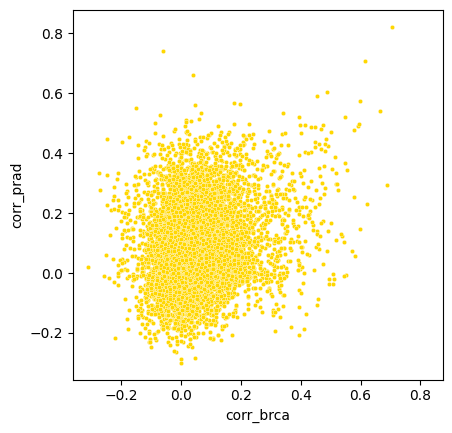

In [133]:
sns.scatterplot(data=dtype_to_df['vishd'], x='corr_brca', y='corr_prad', c='gold', s=10)
plt.axis('square')

In [134]:
f = dtype_to_df['vishd'].copy()
f['score'] = f['corr_brca'] * f['corr_prad']

In [135]:
x = f[f['corr_brca'] > .4]
x = x[x['corr_prad'] > .4]
genes = x.sort_values('score', ascending=False).index.to_list()
gene_lists['combined_positive'] += genes
for g in genes: print(g)

KRT5
TRIM29
KRT17
LAMB3
ITGB4
GSTP1
DST
DSC3
WFDC2
TP63
ITGA2
ANXA1
TNS4
OBSCN
ITGB8
SLPI
A2M
F3
S100A6
COL7A1
EFNA5
ITGB6
TINAGL1
ITGA3
PERP
DEFB1
SCPEP1
PIK3R1


In [136]:
x = f[f['corr_brca'] > .4]
x = x[x['corr_prad'] < .1]
genes = x.sort_values('corr_prad', ascending=True).index.to_list()
gene_lists['brca_positive'] += genes
for g in genes: print(g)

ANPEP
IRX2
IRX4
FAM20C
NFIX
CCDC9B
MIA
ELF5
PHGDH
KLK5
KRT6B
IRX1
SOX10
KLK7
GUCY1A1
SBSPON
C5orf46
CHI3L1
KCNMB1
PPP1R14C
RASSF10
NFIB
SYNM
CNN1
ECRG4
LAD1
ACTG2
SLC34A2


In [137]:
x = f[f['corr_brca'] < .1]
x = x[x['corr_prad'] > .4]
genes = x.sort_values('corr_brca', ascending=True).index.to_list()
gene_lists['prad_positive'] += genes
for g in genes: print(g)

SERPINF1
C3
RHOB
GJA1
DDIT4
TSC22D3
STOM
CHPT1
XG
APOL1
GLUL
RUNX1
THSD4
BHLHE40
WIPF1
KRT19
KRT15
GPX3
SORL1
CYP4X1
IRX3
SLC2A5
GBP4
ID1
LIPC
SELENOM
EPAS1
APOBR
HOXD10
AVPI1
C1R
SLFN12
NCKAP1L
IFITM3
WNT3A
GRASP
EPB41L2
XAF1
ZFP36L1
TRIB2
CPA6
TMSB4X
UCP2
ANXA2
APOL4
CSF2RA
HOXD11
APOL5
MUC4
CYP3A5
SIRPB2
LGALS3
CYP4B1
RASAL3
SPTLC3
MFSD4A
NTN4
ARRDC2
DBNDD2
RASSF4
CLDN1
CD74
PDK4
HEXA
ZEB2
ARHGEF19
DUOX2
INKA1
ENPP2
TMEM173
KLK11
CD4
S1PR5


In [138]:
x = f[f['corr_brca'] < -.1]
x = x[x['corr_prad'] < -.1]
genes = x.sort_values('score', ascending=False).index.to_list()
gene_lists['combined_negative'] += genes
for g in genes: print(g)

NPNT
FASN
CPNE7
CNTNAP2
MLPH
HID1
TPD52
INPP4B
EEF1A2
ABAT
TP53INP1
GREB1
NPR3
KLK4
ARHGEF38
PYCR1
FOXA1
CRAT
SPDEF
MAPK8IP2
FAM110B
MCCC2
NTNG2
ALCAM
AR
GSE1
STEAP4
PRRT2
PRLR
TRPM4
ABLIM3
ERGIC1


In [139]:
x = f[f['corr_brca'] < -.1]
x = x[x['corr_prad'] > .2]
genes = x.sort_values('corr_prad', ascending=False).index.to_list()
gene_lists['brca_negative'] += genes
for g in genes: print(g)

GJA1
RHOB
SERPINF1
CHPT1
C3
XG
DDIT4
STOM
TSC22D3
CYBRD1
KRT23
TCIM
TIMP2
PREX1
TIMP3
DCN
LPAR5
VWA2
MMP2
PRSS23
FN1
PRRX1
CRISPLD2
LRP1
CCDC3
MAP3K1
SPTSSB
DUSP4
HTRA1
ARHGAP40
TMEM119
SFRP2
LUM
C1S
KLF2
EFHD1
LTBP1
VCAM1
TGFB3
SPARC
MS4A7
PGR
GSTM3
ASPH
SERPINA11
AEBP1
FBLN1
CCN4
COL14A1
FGD3
IGFBP4
COL6A3
SLC38A1
NBL1
RAB31
IGF1
GPRC5A
EMP2
SPON1
CTSK
RASGRF2
CCDC80
ELN
MAN1A1
ETNK2
COL1A2
COL3A1


In [140]:
x = f[f['corr_brca'] > .2]
x = x[x['corr_prad'] < -.1]
genes = x.sort_values('corr_brca', ascending=False).index.to_list()
gene_lists['prad_negative'] += genes
for g in genes: print(g)

IRX4
IRX2
ANPEP
PPP1R1B
LGR4
DLGAP1
IRS2
LARGE2
C1orf116
AMOTL1
TMPRSS2
TUSC3
SPTBN2
PLEKHB1
SLC25A37
LRATD1
BICD1
MESP1
ZNF462
RASSF3
MSI1


In [141]:
for disease, d1 in to_gene_corr_sources.items():
    for dti, d2 in d1.items():
        for direction, f in d2.items():
            key = f'{disease}_{direction}'
            gene_lists[key] += f.index.to_list()

for k, v in gene_lists.items():
    print(k, len(set(v)))

for disease, d1 in to_gene_consensus_corr_sources.items():
    for direction, f in d1.items():
        key = f'{disease}_{direction}'
        gene_lists[key] += f.index.to_list()

for k, v in gene_lists.items():
    print(k, len(set(v)))

diseases = ['brca', 'prad']
dtypes = ['xenium', 'cosmx', 'vishd']
idents = ['region', 'tme']
exclude = ['celltypes', 'nbhd', 'myoepithelial', 'epithelial']
tups = [(ident, dtype) for ident in idents for dtype in dtypes]
for i, disease in enumerate(diseases):
    for j, dtype in enumerate(dtypes):
        for k, ident in enumerate(idents):
            df = corr_dfs[f'{disease}_{dtype}_{ident}']
            idxs = [i for i in df.index.to_list() if not len([x for x in exclude if x in i])]
            source = df.loc[idxs]
            source = source[~pd.isnull(source['correlation'])]
            if source.shape[0]:
                if n * 2 < source.shape[0]:
                    source = pd.concat((source.iloc[:n], source.iloc[-n:]))
                source = source.sort_values('correlation', ascending=False)
                source.index = [c.replace(f'region_', '').replace('tme_', '') for c in source.index.to_list()]

                for feat, corr in zip(source.index.to_list(), source['correlation']):
                    if corr > 0:
                        gene_lists[f'{disease}_positive'].append(feat)
                    else:
                        gene_lists[f'{disease}_negative'].append(feat)

for k, v in gene_lists.items():
    print(k, len(set(v)))

brca_positive 100
brca_negative 120
prad_positive 142
prad_negative 76
combined_positive 48
combined_negative 39
brca_positive 102
brca_negative 122
prad_positive 151
prad_negative 77
combined_positive 48
combined_negative 39
brca_positive 131
brca_negative 147
prad_positive 167
prad_negative 88
combined_positive 48
combined_negative 39


In [142]:

a = set(gene_lists['brca_positive'])
b = set(gene_lists['prad_positive'])
common = a.intersection(b)

a -= common
b -= common
c = set(gene_lists['combined_positive'])
d = set.union(common, c)

gene_lists['brca_positive'] = sorted(a)
gene_lists['prad_positive'] = sorted(b)
gene_lists['combined_positive'] = sorted(d)

a = set(gene_lists['brca_negative'])
b = set(gene_lists['prad_negative'])
common = a.intersection(b)

a -= common
b -= common
c = set(gene_lists['combined_negative'])
d = set.union(common, c)

gene_lists['brca_negative'] = sorted(a)
gene_lists['prad_negative'] = sorted(b)
gene_lists['combined_negative'] = sorted(d)

for k, v in gene_lists.items():
    print(k, len(set(v)))

brca_positive 100
brca_negative 145
prad_positive 136
prad_negative 86
combined_positive 61
combined_negative 39


In [143]:
for k, v in gene_lists.items():
    print(k)
    for x in v:
        print(x)

    print()
    print()
    print()

brca_positive
ACTA2
ACTG2
ANPEP
ANXA1
APP
ARFGEF3
BBOX1
C5orf46
CALD1
CALML3
CCDC9B
CDH1
CDH3
CHI3L1
CNN1
CRYAB
DSG3
ECRG4
ELF5
EPHB4
ERG
FAM20C
FBLN1
GAS6
GUCY1A1
IFFO2
IFI44L
IRX1
IRX2
IRX4
ITGA2
ITGA3
JUN
KCNMB1
KITLG
KLK5
KLK7
KRT6A/B/C
KRT6B
LAD1
LAMC2
LEPR
MAMDC2
MBP
MGP
MIA
MMP7
MMRN2
MUC1
MYH11
MYL9
MYLK
NFIB
NFIX
NGFR
NTRK2
PDGFRA
PDLIM4
PHGDH
PLAT
PPP1R14C
PPP1R1B
PTCH1
PTN
RASSF10
S100A2
SAA1/2
SBSPON
SCNN1A
SFN
SLC34A2
SLC39A6
SNCG
SOX10
SREBF1
STC2
SYNM
SYT8
TACSTD2
TAGLN
TBX18
TCIM
TFPI
THBS1
TINAGL1
TLE4
TM4SF18
TMPRSS2
TPM2
WFDC2
cd11b
ckit
cox6c
ctla4
her2
ki67
mgp
plat/tpa
slc39a6
tff1



brca_negative
ADAM8
AEBP1
AREG
ARHGAP40
ASPH
ASPN
ASXL1_p.P808Lfs__10_WT
ATP6V1C1
AZGP1
BAMBI
BLANK_0416
BRCA2_p.A938fs_ALT:-
C15orf48
C1S
C3
CCDC3
CCDC78
CCDC80
CCN4
CCND1
CDKN2A
CDKN2A_p14arf
CDKN2A_p16
CENPF
CHPT1
CILP
CILP2
COL10A1
COL11A1
COL12A1
COL14A1
COL1A1
COL1A2
COL3A1
COL5A2
COL6A3
COL8A1
COMP
COX6C
CRISPLD2
CTNNB1_p.S45Y_ALT:A
CTSK
CXCL12
CXCL9
CYBRD1
DCN
DDIT4
DPT
DUSP4

In [1006]:
for k, vs in gene_lists.items():
    for v in vs:
        print(f'{k}\t{v}')

brca_positive	ACTA2
brca_positive	ACTG2
brca_positive	ANPEP
brca_positive	ANXA1
brca_positive	APP
brca_positive	ARFGEF3
brca_positive	BBOX1
brca_positive	C5orf46
brca_positive	CALD1
brca_positive	CALML3
brca_positive	CCDC9B
brca_positive	CDH1
brca_positive	CDH3
brca_positive	CHI3L1
brca_positive	CNN1
brca_positive	CRYAB
brca_positive	DSG3
brca_positive	ECRG4
brca_positive	ELF5
brca_positive	ERG
brca_positive	FAM20C
brca_positive	FBLN1
brca_positive	GAS6
brca_positive	GUCY1A1
brca_positive	IFFO2
brca_positive	IFI44L
brca_positive	IRX1
brca_positive	IRX2
brca_positive	IRX4
brca_positive	ITGA2
brca_positive	ITGA3
brca_positive	JUN
brca_positive	KCNMB1
brca_positive	KITLG
brca_positive	KLK5
brca_positive	KLK7
brca_positive	KRT6A/B/C
brca_positive	KRT6B
brca_positive	LAD1
brca_positive	LAMC2
brca_positive	LEPR
brca_positive	MAMDC2
brca_positive	MBP
brca_positive	MGP
brca_positive	MIA
brca_positive	MMP7
brca_positive	MMRN2
brca_positive	MUC1
brca_positive	MYH11
brca_positive	MYL9
brca_positi